# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/train",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/valid",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7665 files belonging to 4 classes.
==========================Validation Data====================
Found 1855 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Corn/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Corn/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7665 images belonging to 4 classes.
Found 1855 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Mon May 29 12:45:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P0               36W /  N/A|   4791MiB /  6144MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## DIY Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_DIY_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7435
Epoch 1: val_accuracy improved from -inf to 0.88625, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 117s 296ms/step - loss: 0.6723 - accuracy: 0.7435 - val_loss: 0.3238 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.8489
Epoch 2: val_accuracy did not improve from 0.88625
384/384 [==============================] - 66s 171ms/step - loss: 0.3926 - accuracy: 0.8489 - val_loss: 0.4378 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8578
Epoch 3: val_accuracy improved from 0.88625 to 0.91051, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 67s 175ms/step - loss: 0.3695 - accuracy: 0.8578 - val_loss: 0.2410 - val_accuracy: 0.9105 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8772
Epoch 4: val_accuracy did not improve from 0.91051
384/384 [==============================] - 65s 169ms/step - loss: 0.3232 - accuracy: 0.8772 - val_loss: 0.2532 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8822
Epoch 5: val_accuracy improved from 0.91051 to 0.91267, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 68s 176ms/step - loss: 0.3078 - accuracy: 0.8822 - val_loss: 0.2414 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8822
Epoch 6: val_accuracy improved from 0.91267 to 0.92129, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 67s 175ms/step - loss: 0.3042 - accuracy: 0.8822 - val_loss: 0.2105 - val_accuracy: 0.9213 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8928
Epoch 7: val_accuracy did not improve from 0.92129
384/384 [==============================] - 67s 173ms/step - loss: 0.2780 - accuracy: 0.8928 - val_loss: 0.2962 - val_accuracy: 0.8987 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9002
Epoch 8: val_accuracy improved from 0.92129 to 0.92453, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 70s 182ms/step - loss: 0.2589 - accuracy: 0.9002 - val_loss: 0.1849 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 9/100
384/384 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.8904
Epoch 9: val_accuracy improved from 0.92453 to 0.92507, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 69s 179ms/step - loss: 0.2882 - accuracy: 0.8904 - val_loss: 0.1917 - val_accuracy: 0.9251 - lr: 0.0010
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9049
Epoch 10: val_accuracy improved from 0.92507 to 0.94070, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 68s 178ms/step - loss: 0.2525 - accuracy: 0.9049 - val_loss: 0.1767 - val_accuracy: 0.9407 - lr: 0.0010
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.8903
Epoch 11: val_accuracy did not improve from 0.94070
384/384 [==============================] - 65s 170ms/step - loss: 0.2878 - accuracy: 0.8903 - val_loss: 0.2973 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.9006
Epoch 12: val_accuracy did not improve from 0.94070
384/384 [==============================] - 63s 165ms/step - loss: 0.2626 - accuracy: 0.9006 - val_loss: 0.1784 - val_accuracy: 0.9391 - lr: 0.0010
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.9066
Epoch 13: val_accuracy did not improve from 0.94070
384/384 [==============================] - 64s 168ms/step - loss: 0.2494 - accuracy: 0.9066 - val_loss: 0.212

INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 68s 177ms/step - loss: 0.2163 - accuracy: 0.9159 - val_loss: 0.1856 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 16/100
384/384 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9251
Epoch 16: val_accuracy improved from 0.94124 to 0.94663, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 68s 178ms/step - loss: 0.1958 - accuracy: 0.9251 - val_loss: 0.1501 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9199
Epoch 17: val_accuracy improved from 0.94663 to 0.95040, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 72s 187ms/step - loss: 0.2058 - accuracy: 0.9199 - val_loss: 0.1364 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 18/100
384/384 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9260
Epoch 18: val_accuracy did not improve from 0.95040
384/384 [==============================] - 67s 173ms/step - loss: 0.1958 - accuracy: 0.9260 - val_loss: 0.1717 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 19/100
384/384 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9207
Epoch 19: val_accuracy improved from 0.95040 to 0.95148, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 71s 185ms/step - loss: 0.2013 - accuracy: 0.9207 - val_loss: 0.1312 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 20/100
384/384 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9280
Epoch 20: val_accuracy improved from 0.95148 to 0.95526, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 68s 176ms/step - loss: 0.1877 - accuracy: 0.9280 - val_loss: 0.1155 - val_accuracy: 0.9553 - lr: 0.0010
Epoch 21/100
384/384 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9272
Epoch 21: val_accuracy did not improve from 0.95526
384/384 [==============================] - 65s 170ms/step - loss: 0.1904 - accuracy: 0.9272 - val_loss: 0.1720 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 22/100
384/384 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9298
Epoch 22: val_accuracy improved from 0.95526 to 0.95687, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 68s 177ms/step - loss: 0.1813 - accuracy: 0.9298 - val_loss: 0.1177 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 23/100
384/384 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9365
Epoch 23: val_accuracy did not improve from 0.95687
384/384 [==============================] - 65s 169ms/step - loss: 0.1773 - accuracy: 0.9365 - val_loss: 0.1222 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 24/100
384/384 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9314
Epoch 24: val_accuracy did not improve from 0.95687
384/384 [==============================] - 62s 161ms/step - loss: 0.1850 - accuracy: 0.9314 - val_loss: 0.1470 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 25/100
384/384 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.9395
Epoch 25: val_accuracy improved from 0.95687 to 0.95957, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 98s 256ms/step - loss: 0.1633 - accuracy: 0.9395 - val_loss: 0.1087 - val_accuracy: 0.9596 - lr: 0.0010
Epoch 26/100
384/384 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.9392
Epoch 26: val_accuracy improved from 0.95957 to 0.96011, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 82s 213ms/step - loss: 0.1601 - accuracy: 0.9392 - val_loss: 0.1140 - val_accuracy: 0.9601 - lr: 0.0010
Epoch 27/100
384/384 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9362
Epoch 27: val_accuracy improved from 0.96011 to 0.96280, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 65s 170ms/step - loss: 0.1672 - accuracy: 0.9362 - val_loss: 0.1084 - val_accuracy: 0.9628 - lr: 0.0010
Epoch 28/100
384/384 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9401
Epoch 28: val_accuracy did not improve from 0.96280
384/384 [==============================] - 70s 182ms/step - loss: 0.1638 - accuracy: 0.9401 - val_loss: 0.1535 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 29/100
384/384 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9346
Epoch 29: val_accuracy did not improve from 0.96280
384/384 [==============================] - 72s 188ms/step - loss: 0.1682 - accuracy: 0.9346 - val_loss: 0.1296 - val_accuracy: 0.9585 - lr: 0.0010
Epoch 30/100
384/384 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9366
Epoch 30: val_accuracy did not improve from 0.96280
384/384 [==============================] - 72s 187ms/step - loss: 0.1654 - accuracy: 0.9366 - val_loss: 0.119

INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 68s 178ms/step - loss: 0.1586 - accuracy: 0.9412 - val_loss: 0.1077 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 36/100
384/384 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9457
Epoch 36: val_accuracy did not improve from 0.96442

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
384/384 [==============================] - 70s 182ms/step - loss: 0.1525 - accuracy: 0.9457 - val_loss: 0.1113 - val_accuracy: 0.9585 - lr: 0.0010
Epoch 37/100
384/384 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9554
Epoch 37: val_accuracy improved from 0.96442 to 0.96873, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 67s 174ms/step - loss: 0.1151 - accuracy: 0.9554 - val_loss: 0.0797 - val_accuracy: 0.9687 - lr: 1.0000e-04
Epoch 38/100
384/384 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9606
Epoch 38: val_accuracy improved from 0.96873 to 0.96927, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 74s 191ms/step - loss: 0.1009 - accuracy: 0.9606 - val_loss: 0.0808 - val_accuracy: 0.9693 - lr: 1.0000e-04
Epoch 39/100
384/384 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9615
Epoch 39: val_accuracy did not improve from 0.96927
384/384 [==============================] - 62s 160ms/step - loss: 0.1035 - accuracy: 0.9615 - val_loss: 0.0711 - val_accuracy: 0.9693 - lr: 1.0000e-04
Epoch 40/100
384/384 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9572
Epoch 40: val_accuracy improved from 0.96927 to 0.97466, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 73s 189ms/step - loss: 0.1023 - accuracy: 0.9572 - val_loss: 0.0661 - val_accuracy: 0.9747 - lr: 1.0000e-04
Epoch 41/100
384/384 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9607
Epoch 41: val_accuracy did not improve from 0.97466
384/384 [==============================] - 64s 165ms/step - loss: 0.0989 - accuracy: 0.9607 - val_loss: 0.0672 - val_accuracy: 0.9747 - lr: 1.0000e-04
Epoch 42/100
384/384 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9602
Epoch 42: val_accuracy improved from 0.97466 to 0.97574, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 74s 193ms/step - loss: 0.0961 - accuracy: 0.9602 - val_loss: 0.0703 - val_accuracy: 0.9757 - lr: 1.0000e-04
Epoch 43/100
384/384 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9650
Epoch 43: val_accuracy did not improve from 0.97574
384/384 [==============================] - 65s 169ms/step - loss: 0.0934 - accuracy: 0.9650 - val_loss: 0.0704 - val_accuracy: 0.9752 - lr: 1.0000e-04
Epoch 44/100
384/384 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9636
Epoch 44: val_accuracy did not improve from 0.97574
384/384 [==============================] - 66s 172ms/step - loss: 0.0949 - accuracy: 0.9636 - val_loss: 0.0676 - val_accuracy: 0.9752 - lr: 1.0000e-04
Epoch 45/100
384/384 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9635
Epoch 45: val_accuracy did not improve from 0.97574
384/384 [==============================] - 65s 169ms/step - loss: 0.0967 - accuracy: 0.9635 - val

INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 70s 183ms/step - loss: 0.0898 - accuracy: 0.9659 - val_loss: 0.0604 - val_accuracy: 0.9768 - lr: 1.0000e-04
Epoch 51/100
384/384 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9657
Epoch 51: val_accuracy improved from 0.97682 to 0.97951, saving model to Corn_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


384/384 [==============================] - 77s 200ms/step - loss: 0.0877 - accuracy: 0.9657 - val_loss: 0.0569 - val_accuracy: 0.9795 - lr: 1.0000e-04
Epoch 52/100
384/384 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9661
Epoch 52: val_accuracy did not improve from 0.97951
384/384 [==============================] - 71s 185ms/step - loss: 0.0870 - accuracy: 0.9661 - val_loss: 0.0601 - val_accuracy: 0.9763 - lr: 1.0000e-04
Epoch 53/100
384/384 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9669
Epoch 53: val_accuracy did not improve from 0.97951
384/384 [==============================] - 68s 178ms/step - loss: 0.0844 - accuracy: 0.9669 - val_loss: 0.0605 - val_accuracy: 0.9752 - lr: 1.0000e-04
Epoch 54/100
384/384 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9689
Epoch 54: val_accuracy did not improve from 0.97951
384/384 [==============================] - 67s 174ms/step - loss: 0.0800 - accuracy: 0.9689 - val

INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model1_Based_Augmented\assets



Epoch 61: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
384/384 [==============================] - 70s 183ms/step - loss: 0.0777 - accuracy: 0.9683 - val_loss: 0.0571 - val_accuracy: 0.9801 - lr: 1.0000e-05
Epoch 62/100
384/384 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9686
Epoch 62: val_accuracy did not improve from 0.98005
384/384 [==============================] - 63s 164ms/step - loss: 0.0768 - accuracy: 0.9686 - val_loss: 0.0569 - val_accuracy: 0.9801 - lr: 1.0000e-06
Epoch 63/100
384/384 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9721
Epoch 63: val_accuracy did not improve from 0.98005
384/384 [==============================] - 63s 165ms/step - loss: 0.0744 - accuracy: 0.9721 - val_loss: 0.0567 - val_accuracy: 0.9795 - lr: 1.0000e-06
Epoch 64/100
384/384 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9708
Epoch 64: val_accuracy did not improve from 0.98005
384/384 [=========

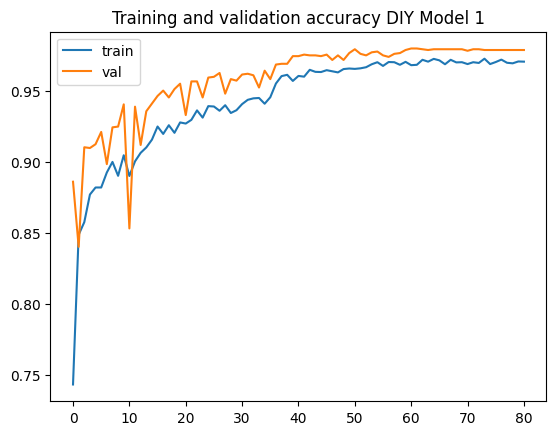

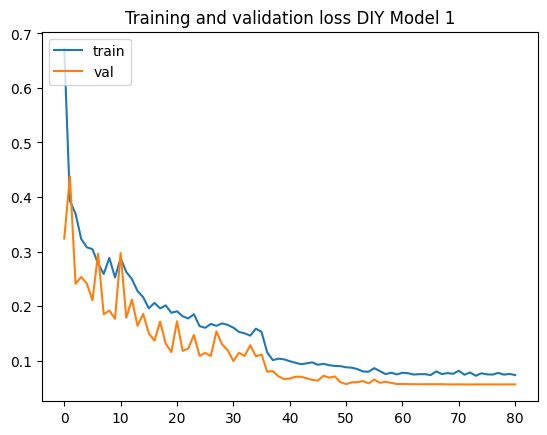

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_DIY_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.7755
Epoch 1: val_accuracy improved from -inf to 0.86900, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 67s 173ms/step - loss: 0.5743 - accuracy: 0.7755 - val_loss: 0.3189 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.8680
Epoch 2: val_accuracy did not improve from 0.86900
384/384 [==============================] - 62s 160ms/step - loss: 0.3582 - accuracy: 0.8680 - val_loss: 0.4062 - val_accuracy: 0.8431 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8795
Epoch 3: val_accuracy did not improve from 0.86900
384/384 [==============================] - 62s 160ms/step - loss: 0.3149 - accuracy: 0.8795 - val_loss: 0.4345 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.8823
Epoch 4: val_accuracy improved from 0.86900 to 0.91968, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 68s 176ms/step - loss: 0.2976 - accuracy: 0.8823 - val_loss: 0.2352 - val_accuracy: 0.9197 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8882
Epoch 5: val_accuracy improved from 0.91968 to 0.92884, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 66s 171ms/step - loss: 0.2950 - accuracy: 0.8882 - val_loss: 0.2042 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.2539 - accuracy: 0.9028
Epoch 6: val_accuracy did not improve from 0.92884
384/384 [==============================] - 58s 150ms/step - loss: 0.2539 - accuracy: 0.9028 - val_loss: 0.1828 - val_accuracy: 0.9278 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.8998
Epoch 7: val_accuracy did not improve from 0.92884
384/384 [==============================] - 58s 152ms/step - loss: 0.2721 - accuracy: 0.8998 - val_loss: 0.3217 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9041
Epoch 8: val_accuracy improved from 0.92884 to 0.93585, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 67s 173ms/step - loss: 0.2556 - accuracy: 0.9041 - val_loss: 0.1971 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 9/100
384/384 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.9091
Epoch 9: val_accuracy improved from 0.93585 to 0.94609, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 67s 175ms/step - loss: 0.2438 - accuracy: 0.9091 - val_loss: 0.1531 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9101
Epoch 10: val_accuracy did not improve from 0.94609
384/384 [==============================] - 59s 153ms/step - loss: 0.2359 - accuracy: 0.9101 - val_loss: 0.2653 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9151
Epoch 11: val_accuracy did not improve from 0.94609
384/384 [==============================] - 59s 152ms/step - loss: 0.2330 - accuracy: 0.9151 - val_loss: 0.1749 - val_accuracy: 0.9272 - lr: 0.0010
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.9027
Epoch 12: val_accuracy did not improve from 0.94609
384/384 [==============================] - 58s 151ms/step - loss: 0.2621 - accuracy: 0.9027 - val_loss: 0.236

INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 67s 176ms/step - loss: 0.1984 - accuracy: 0.9263 - val_loss: 0.1261 - val_accuracy: 0.9601 - lr: 0.0010
Epoch 15/100
384/384 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9241
Epoch 15: val_accuracy did not improve from 0.96011
384/384 [==============================] - 58s 150ms/step - loss: 0.2071 - accuracy: 0.9241 - val_loss: 0.1433 - val_accuracy: 0.9585 - lr: 0.0010
Epoch 16/100
384/384 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9292
Epoch 16: val_accuracy did not improve from 0.96011
384/384 [==============================] - 58s 150ms/step - loss: 0.1840 - accuracy: 0.9292 - val_loss: 0.1756 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9268
Epoch 17: val_accuracy did not improve from 0.96011
384/384 [==============================] - 58s 151ms/step - loss: 0.1864 - accuracy: 0.9268 - val_loss: 0.156

INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 66s 173ms/step - loss: 0.1428 - accuracy: 0.9438 - val_loss: 0.0972 - val_accuracy: 0.9655 - lr: 1.0000e-04
Epoch 21/100
384/384 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9516
Epoch 21: val_accuracy improved from 0.96550 to 0.96873, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 68s 176ms/step - loss: 0.1206 - accuracy: 0.9516 - val_loss: 0.0956 - val_accuracy: 0.9687 - lr: 1.0000e-04
Epoch 22/100
384/384 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9529
Epoch 22: val_accuracy did not improve from 0.96873
384/384 [==============================] - 58s 152ms/step - loss: 0.1204 - accuracy: 0.9529 - val_loss: 0.0989 - val_accuracy: 0.9666 - lr: 1.0000e-04
Epoch 23/100
384/384 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9543
Epoch 23: val_accuracy did not improve from 0.96873
384/384 [==============================] - 59s 153ms/step - loss: 0.1172 - accuracy: 0.9543 - val_loss: 0.1000 - val_accuracy: 0.9677 - lr: 1.0000e-04
Epoch 24/100
384/384 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9575
Epoch 24: val_accuracy improved from 0.96873 to 0.96927, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 67s 175ms/step - loss: 0.1111 - accuracy: 0.9575 - val_loss: 0.0957 - val_accuracy: 0.9693 - lr: 1.0000e-04
Epoch 25/100
384/384 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9562
Epoch 25: val_accuracy did not improve from 0.96927
384/384 [==============================] - 60s 156ms/step - loss: 0.1138 - accuracy: 0.9562 - val_loss: 0.1058 - val_accuracy: 0.9666 - lr: 1.0000e-04
Epoch 26/100
384/384 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9589
Epoch 26: val_accuracy did not improve from 0.96927

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
384/384 [==============================] - 59s 154ms/step - loss: 0.1101 - accuracy: 0.9589 - val_loss: 0.1008 - val_accuracy: 0.9682 - lr: 1.0000e-04
Epoch 27/100
384/384 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9576
Epoch 27: val_accuracy improved from 0.96927 to 0.97251, saving model 

INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 69s 179ms/step - loss: 0.1088 - accuracy: 0.9576 - val_loss: 0.0899 - val_accuracy: 0.9725 - lr: 1.0000e-05
Epoch 28/100
384/384 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9596
Epoch 28: val_accuracy improved from 0.97251 to 0.97358, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 69s 179ms/step - loss: 0.1049 - accuracy: 0.9596 - val_loss: 0.0856 - val_accuracy: 0.9736 - lr: 1.0000e-05
Epoch 29/100
384/384 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9589
Epoch 29: val_accuracy did not improve from 0.97358
384/384 [==============================] - 59s 153ms/step - loss: 0.1033 - accuracy: 0.9589 - val_loss: 0.0867 - val_accuracy: 0.9725 - lr: 1.0000e-05
Epoch 30/100
384/384 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9606
Epoch 30: val_accuracy did not improve from 0.97358
384/384 [==============================] - 59s 154ms/step - loss: 0.1039 - accuracy: 0.9606 - val_loss: 0.0856 - val_accuracy: 0.9725 - lr: 1.0000e-05
Epoch 31/100
384/384 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9609
Epoch 31: val_accuracy improved from 0.97358 to 0.97412, saving model to Corn_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DIY_model2_Based_Augmented\assets


384/384 [==============================] - 68s 178ms/step - loss: 0.0944 - accuracy: 0.9609 - val_loss: 0.0857 - val_accuracy: 0.9741 - lr: 1.0000e-05
Epoch 32/100
384/384 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9597
Epoch 32: val_accuracy did not improve from 0.97412
384/384 [==============================] - 59s 154ms/step - loss: 0.1037 - accuracy: 0.9597 - val_loss: 0.0859 - val_accuracy: 0.9730 - lr: 1.0000e-05
Epoch 33/100
384/384 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9583
Epoch 33: val_accuracy did not improve from 0.97412

Epoch 33: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
384/384 [==============================] - 58s 152ms/step - loss: 0.1013 - accuracy: 0.9583 - val_loss: 0.0878 - val_accuracy: 0.9714 - lr: 1.0000e-05
Epoch 34/100
384/384 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9616
Epoch 34: val_accuracy did not improve from 0.97412
384/384 [=========

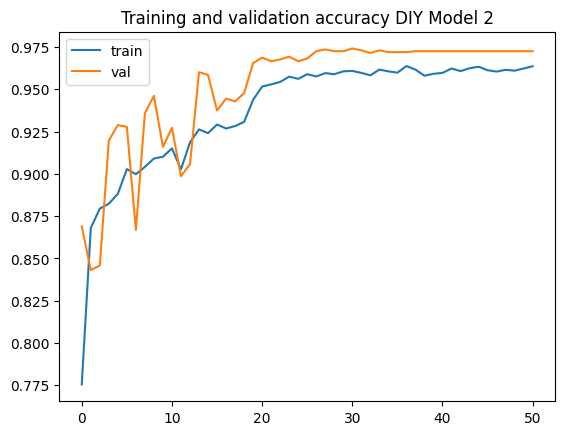

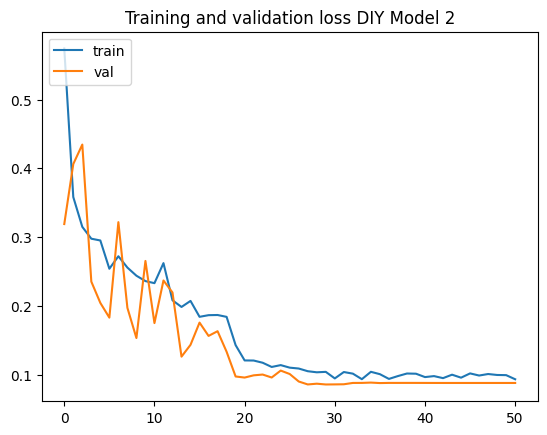

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')